# CATBOOST

Librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report,
                             f1_score, precision_score, recall_score, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.model_selection import StratifiedKFold
from tools import optimizar_threshold_costo_cv, evaluate_model

Dataset

In [2]:
dataset = pd.read_csv('../../data/processed/fraud_dataset_processed.csv')

In [3]:
# Mover la columna "fraude" al final a la derecha
# Nos quedamos solo con las columnas numéricas (más la columna 'fraude' si existe)
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

# EXCLUIR columnas que pueden causar data leakage
columns_to_exclude = ['fraude', 'row_id', 'Unnamed: 0', 'score']
if 'fraude' in numeric_cols:
    numeric_cols.remove('fraude')
for col in columns_to_exclude:
    if col in numeric_cols:
        numeric_cols.remove(col)

# Agregar 'fraude' al final
if 'fraude' in dataset.columns:
    numeric_cols.append('fraude')

dataset = dataset[numeric_cols]

# Verificar columnas usadas
print(f"Total de columnas numéricas (sin 'fraude'): {len(numeric_cols) - 1}")
print(f"Columnas usadas: {numeric_cols[:-1] if 'fraude' in numeric_cols else numeric_cols}")

Total de columnas numéricas (sin 'fraude'): 45
Columnas usadas: ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'k', 'l', 'm', 'n', 'q', 'r', 's', 'monto', 'o_is_N', 'o_is_Y', 'o_is_NA', 'b_imputado', 'c_imputado', 'd_imputado', 'f_imputado', 'q_imputado', 'l_imputado', 'm_imputado', 'categoria_id_target_enc', 'categoria_id_freq_enc', 'pais_target_enc', 'pais_freq_enc', 'producto_num_chars', 'producto_num_words', 'producto_num_special_chars', 'producto_avg_word_len', 'producto_freq', 'hora', 'dia_semana', 'dia_mes', 'mes', 'es_fin_de_semana', 'es_nocturno', 'es_horario_laboral', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos']


In [4]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Obtener nombres de columnas para análisis
feature_names = dataset.columns[:-1].tolist()

# Verificar distribución de clases
print("=" * 80)
print("DISTRIBUCIÓN DE CLASES")
print("=" * 80)
print(f"Clase 0 (No Fraude): {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.2f}%)")
print(f"Clase 1 (Fraude):    {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.2f}%)")
print(f"Total:               {len(y):,}")

# Calcular ratio de desbalance para balanceo
fraud_count = np.sum(y == 1)
non_fraud_count = np.sum(y == 0)
if fraud_count > 0:
    scale_pos_weight = non_fraud_count / fraud_count
    print(f"\nRatio de desbalance (scale_pos_weight): {scale_pos_weight:.2f}")
else:
    scale_pos_weight = 1.0
    print("\n⚠️ ERROR: No hay casos de fraude!")

# ⚠️ VERIFICAR DATA LEAKAGE: Correlación con target
print("\n" + "=" * 80)
print("VERIFICACIÓN DE DATA LEAKAGE")
print("=" * 80)
X_df = pd.DataFrame(X, columns=feature_names)
y_series = pd.Series(y)

# Calcular correlaciones con el target
correlations = X_df.corrwith(y_series).abs().sort_values(ascending=False)
print("\nTop 10 columnas con mayor correlación con 'fraude':")
print(correlations.head(10))

# Verificar si hay correlación perfecta o casi perfecta
high_corr = correlations[correlations > 0.95]
if len(high_corr) > 0:
    print(f"\n⚠️ ADVERTENCIA: {len(high_corr)} columna(s) con correlación > 0.95 con el target:")
    print(high_corr)
    print("\n⚠️ Esto puede indicar DATA LEAKAGE!")
else:
    print("\n✅ No se encontraron correlaciones perfectas (>0.95) con el target")

# Verificar si alguna columna predice perfectamente el target
print("\n" + "-" * 80)
print("Verificando si alguna columna predice perfectamente el target...")
perfect_predictors = []
for col in feature_names:
    col_idx = feature_names.index(col)
    col_values = X[:, col_idx]
    
    # Verificar si los valores únicos de la columna coinciden perfectamente con el target
    # (esto indicaría que la columna es casi idéntica al target)
    unique_vals = np.unique(col_values)
    
    # Si la columna tiene solo 2 valores únicos (como el target), verificar si coincide
    if len(unique_vals) == 2:
        # Crear un mapeo binario
        val0, val1 = unique_vals
        col_binary = (col_values == val1).astype(int)
        if np.array_equal(col_binary, y):
            perfect_predictors.append(col)
            print(f"⚠️ {col}: Predice PERFECTAMENTE el target (coincidencia 100%)")

if len(perfect_predictors) > 0:
    print(f"\n⚠️ ADVERTENCIA CRÍTICA: {len(perfect_predictors)} columna(s) predicen perfectamente el target:")
    print(perfect_predictors)
    print("⚠️ Estas columnas deben ser ELIMINADAS - son DATA LEAKAGE!")
else:
    print("✅ No se encontraron columnas que predigan perfectamente el target")

DISTRIBUCIÓN DE CLASES
Clase 0 (No Fraude): 242,498 (97.00%)
Clase 1 (Fraude):    7,502 (3.00%)
Total:               250,000

Ratio de desbalance (scale_pos_weight): 32.32

VERIFICACIÓN DE DATA LEAKAGE

Top 10 columnas con mayor correlación con 'fraude':
categoria_id_target_enc    0.234866
o_is_N                     0.222080
o_is_NA                    0.173683
n                          0.134382
l                          0.091730
l_imputado                 0.091730
s                          0.083816
m                          0.073017
m_imputado                 0.072965
q                          0.060914
dtype: float64

✅ No se encontraron correlaciones perfectas (>0.95) con el target

--------------------------------------------------------------------------------
Verificando si alguna columna predice perfectamente el target...
✅ No se encontraron columnas que predigan perfectamente el target


In [5]:
# IMPORTANTE: Convertir la columna 'fraude' a binaria (0/1) si fue normalizada
if 'fraude' in dataset.columns:
    # Verificar valores únicos
    unique_values = dataset['fraude'].unique()
    print(f"Valores únicos en 'fraude' (primeros 10): {sorted(unique_values)[:10]}")
    print(f"Tipo de datos: {dataset['fraude'].dtype}")
    print(f"Min: {dataset['fraude'].min()}, Max: {dataset['fraude'].max()}")
    
    # Si tiene valores continuos (normalizados), convertir a binario
    if dataset['fraude'].dtype in ['float64', 'float32']:
        # Si los valores están normalizados (entre 0 y 1), convertir a binario
        if dataset['fraude'].min() >= 0 and dataset['fraude'].max() <= 1:
            # Convertir: > 0.5 = 1, <= 0.5 = 0
            dataset['fraude'] = (dataset['fraude'] > 0.5).astype(int)
            print("✅ Columna 'fraude' convertida de valores normalizados a binaria (0/1)")
        else:
            # Si tiene valores negativos o > 1, usar > 0 como criterio
            dataset['fraude'] = (dataset['fraude'] > 0).astype(int)
            print("✅ Columna 'fraude' convertida a binaria usando > 0 como criterio")
    elif dataset['fraude'].dtype in ['int64', 'int32']:
        # Si ya es entero, verificar si es binario
        unique_ints = set(dataset['fraude'].unique())
        if unique_ints != {0, 1}:
            # Normalizar: cualquier valor > 0 = 1, 0 = 0
            dataset['fraude'] = (dataset['fraude'] > 0).astype(int)
            print("✅ Columna 'fraude' normalizada a binaria (0/1)")
        else:
            print("✅ Columna 'fraude' ya es binaria (0/1)")
    
    # Verificar resultado
    print(f"\nDespués de la conversión:")
    print(f"  Valores únicos: {sorted(dataset['fraude'].unique())}")
    print(f"  Tipo: {dataset['fraude'].dtype}")

Valores únicos en 'fraude' (primeros 10): [np.int64(0), np.int64(1)]
Tipo de datos: int64
Min: 0, Max: 1
✅ Columna 'fraude' ya es binaria (0/1)

Después de la conversión:
  Valores únicos: [np.int64(0), np.int64(1)]
  Tipo: int64


Split Train Test

In [6]:
# Asegurar que y sea binario (0/1) y de tipo entero
y = y.astype(float)  # Primero convertir a float para manejar cualquier tipo
y = (y > 0.5).astype(int)  # Convertir a binario: > 0.5 = 1, <= 0.5 = 0

# Verificar que solo tenga valores 0 y 1
unique_y = np.unique(y)
print(f"Valores únicos en y: {unique_y}")
print(f"Tipo de y: {y.dtype}")

if len(unique_y) > 2 or not all(val in [0, 1] for val in unique_y):
    print(f"⚠️ Advertencia: y tiene valores {unique_y}, forzando a binario")
    y = (y > 0).astype(int)
    print("✅ y convertido a binario (0/1)")

# Verificar distribución de clases
print("\n" + "=" * 80)
print("DISTRIBUCIÓN DE CLASES (DESPUÉS DE CONVERSIÓN)")
print("=" * 80)
print(f"Clase 0 (No Fraude): {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.2f}%)")
print(f"Clase 1 (Fraude):    {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.2f}%)")
print(f"Total:               {len(y):,}")

# Recalcular ratio de desbalance
fraud_count = np.sum(y == 1)
non_fraud_count = np.sum(y == 0)

if fraud_count > 0:
    scale_pos_weight = non_fraud_count / fraud_count
    print(f"\nRatio de desbalance (scale_pos_weight): {scale_pos_weight:.2f}")
else:
    print("\n⚠️ ERROR: No hay casos de fraude en el dataset!")
    scale_pos_weight = 1.0

Valores únicos en y: [0 1]
Tipo de y: int64

DISTRIBUCIÓN DE CLASES (DESPUÉS DE CONVERSIÓN)
Clase 0 (No Fraude): 242,498 (97.00%)
Clase 1 (Fraude):    7,502 (3.00%)
Total:               250,000

Ratio de desbalance (scale_pos_weight): 32.32


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Verificar si hay datos duplicados entre train y test (posible causa de overfitting)
print("=" * 80)
print("VERIFICACIÓN DE DATOS DUPLICADOS")
print("=" * 80)
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Convertir a tuplas para comparar filas completas
train_tuples = [tuple(row) for row in X_train]
test_tuples = [tuple(row) for row in X_test]
train_set = set(train_tuples)
test_set = set(test_tuples)

duplicates = train_set.intersection(test_set)
if len(duplicates) > 0:
    print(f"⚠️ ADVERTENCIA: {len(duplicates)} filas idénticas entre train y test!")
    print("   Esto puede causar overfitting aparente.")
else:
    print("✅ No se encontraron filas idénticas entre train y test")

print(f"\nTrain size: {len(X_train):,}")
print(f"Test size:  {len(X_test):,}")

VERIFICACIÓN DE DATOS DUPLICADOS
✅ No se encontraron filas idénticas entre train y test

Train size: 200,000
Test size:  50,000


Entrenamos

In [8]:
from catboost import CatBoostClassifier

# Asegurar que y_train sea binario y entero
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Calcular class_weights para el conjunto de entrenamiento (BALANCEO)
fraud_count_train = np.sum(y_train == 1)
non_fraud_count_train = np.sum(y_train == 0)

print("=" * 80)
print("BALANCEO DE CLASES")
print("=" * 80)
print(f"No Fraude (train): {non_fraud_count_train:,}")
print(f"Fraude (train):    {fraud_count_train:,}")

if fraud_count_train > 0 and non_fraud_count_train > 0:
    # CatBoost usa class_weights como diccionario
    class_weights = {0: 1.0, 1: non_fraud_count_train / fraud_count_train}
    print(f"class_weights:  {class_weights}")
else:
    print("⚠️ ERROR: No hay suficientes muestras de ambas clases!")
    class_weights = {0: 1.0, 1: 1.0}

# Entrenar modelo con balanceo
print("\n" + "=" * 80)
print("ENTRENANDO MODELO CON BALANCEO")
print("=" * 80)
classifier = CatBoostClassifier(
    class_weights=class_weights,  # Balanceo de clases
    random_state=0,
    iterations=100,
    verbose=False
)
classifier.fit(X_train, y_train)
print("✅ Modelo entrenado con balanceo de clases")

BALANCEO DE CLASES
No Fraude (train): 193,968
Fraude (train):    6,032
class_weights:  {0: 1.0, 1: np.float64(32.15649867374005)}

ENTRENANDO MODELO CON BALANCEO
✅ Modelo entrenado con balanceo de clases


Optimizar treshold por costo

In [9]:
# Optimizar threshold por costo usando Cross-Validation
# Definir costos: FP (False Positive) y FN (False Negative)
# En detección de fraude, un FN (no detectar fraude) suele ser más costoso que un FP (falsas alarmas)
costo_fp = 5.0   # Costo de un False Positive (bloquear transacción legítima)
costo_fn = 100.0  # Costo de un False Negative (no detectar fraude real)

# Configurar Cross-Validation estratificado (mantiene proporción de clases)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

print("=" * 80)
print("OPTIMIZACIÓN DE THRESHOLD POR COSTO")
print("=" * 80)
print(f"Costo FP (False Positive): {costo_fp}")
print(f"Costo FN (False Negative): {costo_fn}")
print(f"Ratio costo FN/FP: {costo_fn/costo_fp:.1f}x")
print("\nOptimizando threshold usando Cross-Validation...")

# Optimizar threshold por costo
resultados_optimizacion = optimizar_threshold_costo_cv(
    model=classifier,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="CatBoost"
)

# Guardar threshold óptimo
threshold_optimo = resultados_optimizacion['threshold_optimo']
costo_minimo = resultados_optimizacion['costo_minimo']

print(f"\n{'='*80}")
print(f"RESUMEN DE OPTIMIZACIÓN")
print(f"{'='*80}")
print(f"Threshold óptimo: {threshold_optimo:.4f}")
print(f"Costo mínimo por 1000 registros: {costo_minimo:.2f}")
print(f"Robustez: {resultados_optimizacion['robustez']}")

OPTIMIZACIÓN DE THRESHOLD POR COSTO
Costo FP (False Positive): 5.0
Costo FN (False Negative): 100.0
Ratio costo FN/FP: 20.0x

Optimizando threshold usando Cross-Validation...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.4020
   Costo mínimo por 1000 registros: 876.23
   FP ajustado: 18329
   FN ajustado: 836

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0181
   Robustez: Muy robusto ✅
   Costo medio por fold: 876.23 ± 15.84

RESUMEN DE OPTIMIZACIÓN
Threshold óptimo: 0.4020
Costo mínimo por 1000 registros: 876.23
Robustez: Muy robusto


Rendimiento


RESULTADOS TEST (Threshold Óptimo por Costo)
EVALUACIÓN DEL MODELO: CatBoost - Test

📌 Threshold usado: 0.4020

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,530 (97.06%)
   Clase 1 (Fraude):    1,470 (2.94%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.8995
   F1 Score:            0.3405 ⭐
   Precision:           0.2110
   Recall (Sensitivity): 0.8830
   Specificity:         0.9000
   ROC AUC:             0.9599
   Average Precision:   0.5620

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.3077
   Matthews Corr Coef:  0.4026
   NPV:                 0.9961
   False Positive Rate: 0.1000

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.2110
   Recall:             0.8830
   F1 Score:           0.3405
   Cohen's Kappa:      0.3077
   Matthews Corr Coef: 0.4026
   Tasa positivos:     0.1231

💰 COSTO:
   Costo por 1000 registros: 829.50
   (Costo FP: 5.0, Costo FN: 100.0)

🔢 MATRIZ DE CONFUSIÓN:
                    Predicción
           

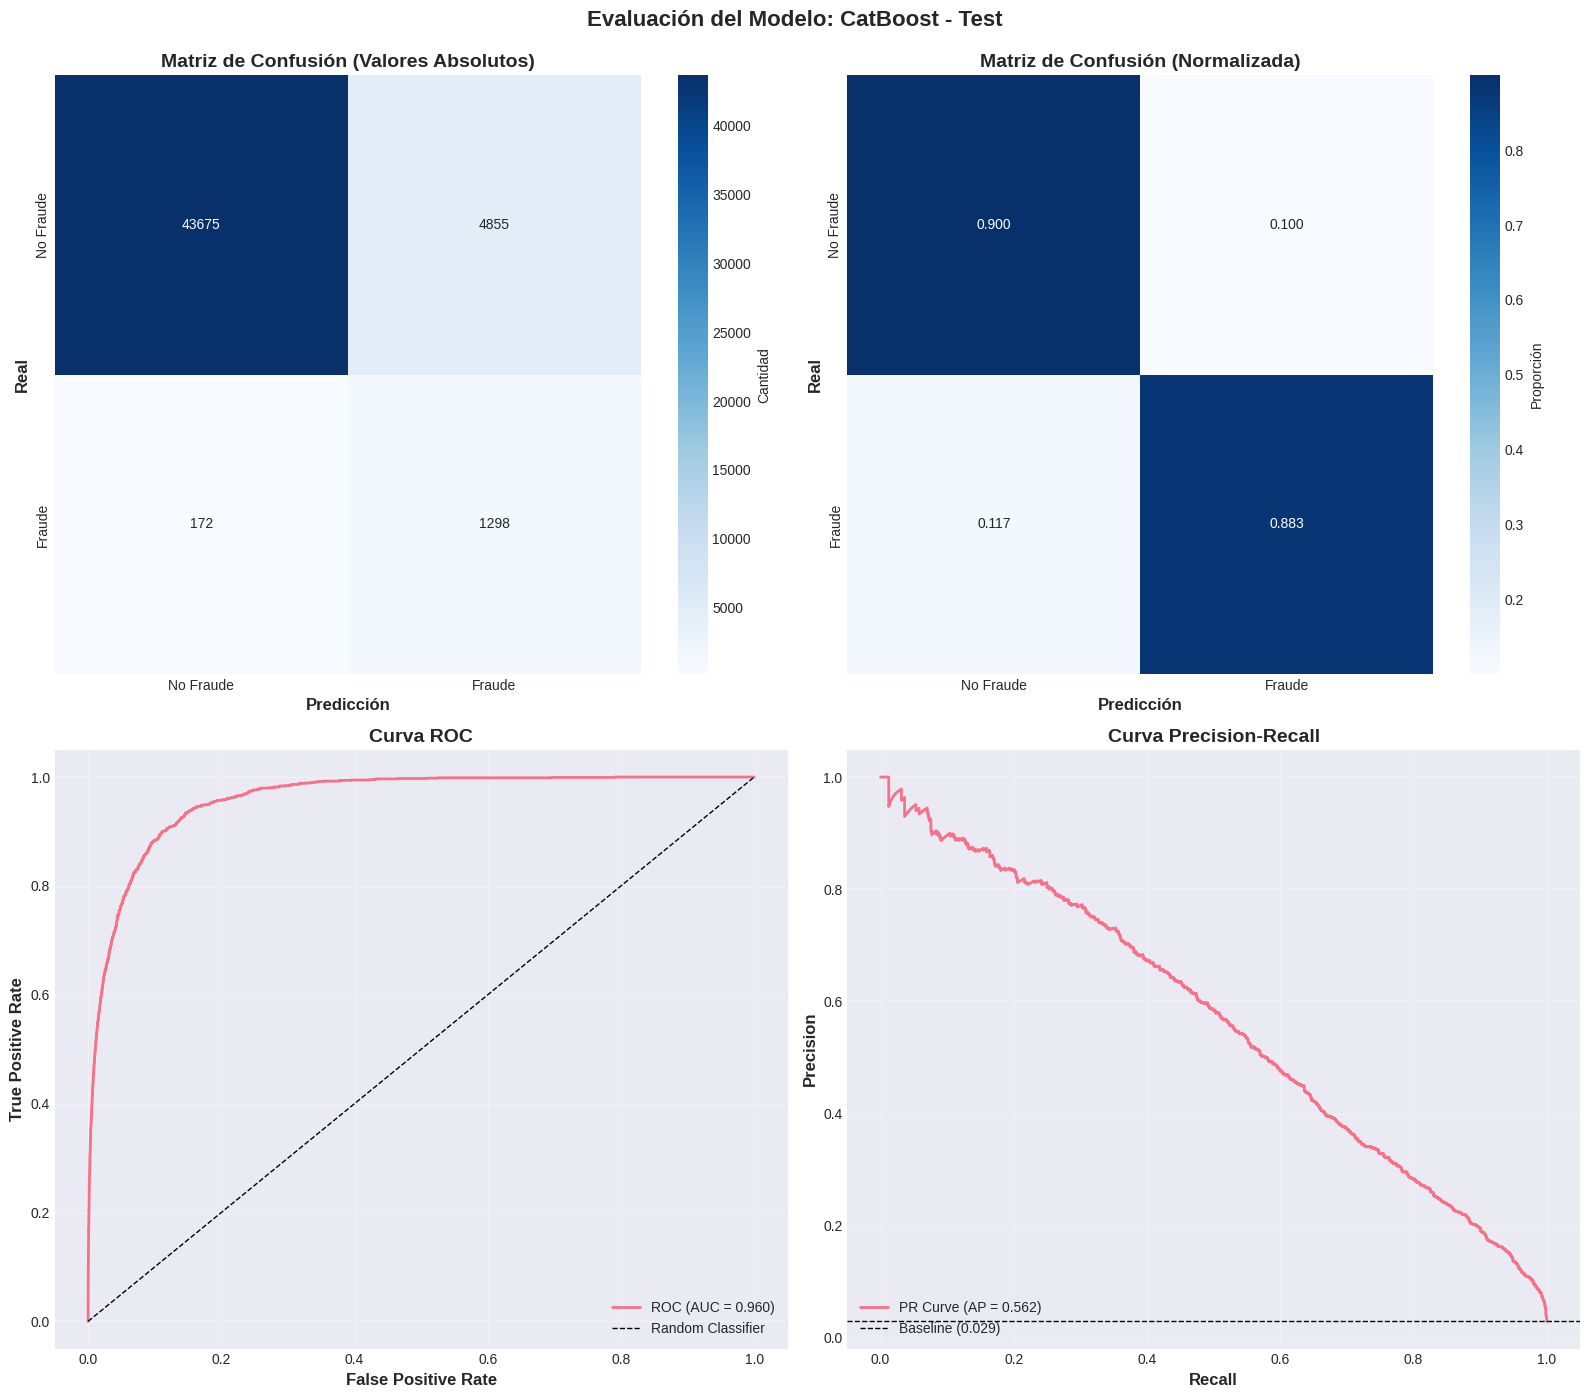

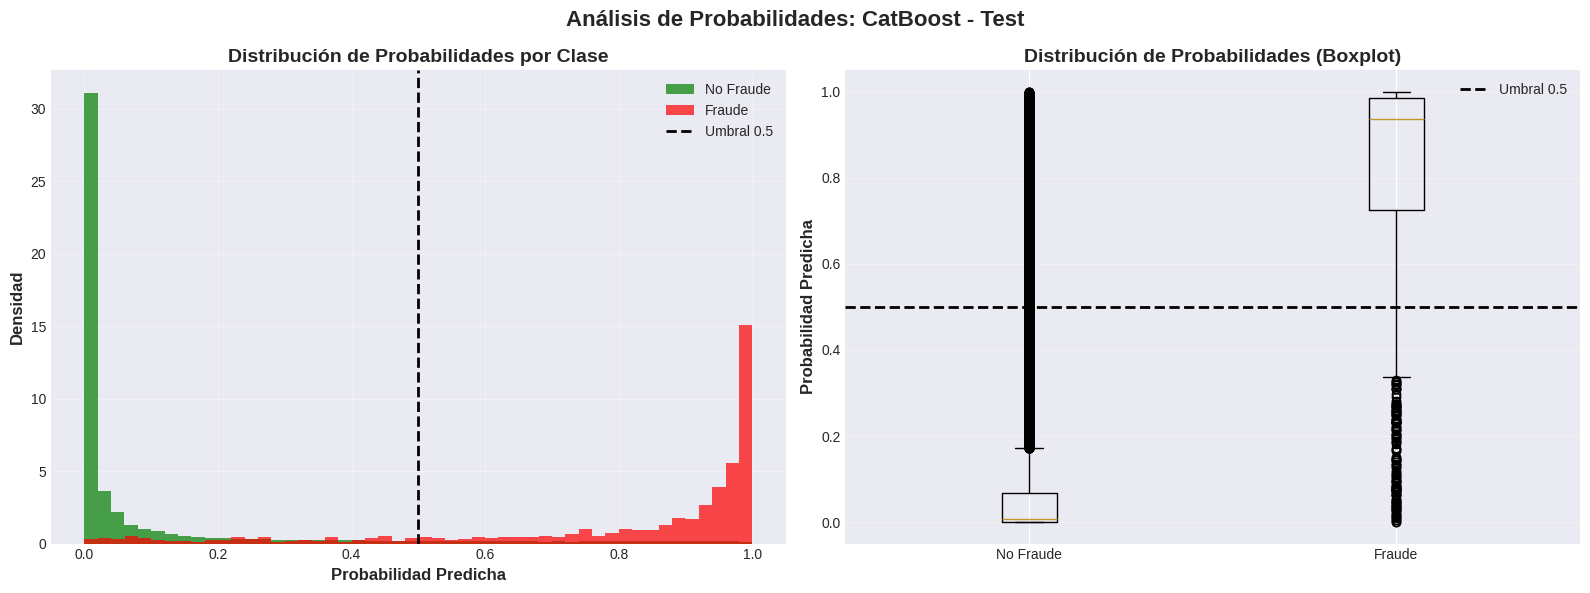

In [11]:
# Evaluar el modelo usando el threshold óptimo y la función evaluate_model
# Obtener probabilidades predichas
y_proba_train = classifier.predict_proba(X_train)[:, 1]
y_proba_test = classifier.predict_proba(X_test)[:, 1]

# Predecir usando threshold óptimo
y_pred_train_optimo = (y_proba_train >= threshold_optimo).astype(int)
y_pred_test_optimo = (y_proba_test >= threshold_optimo).astype(int)

# Evaluar en TEST con threshold óptimo
print("\n" + "=" * 80)
print("RESULTADOS TEST (Threshold Óptimo por Costo)")
print("=" * 80)
metrics_test = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo,
    model_name="CatBoost - Test",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)